In [42]:
%load_ext autoreload
%autoreload 2


from ff_energy.ffe.slurm import SlurmJobHandler
from pathlib import Path
import pandas as pd
import jax.numpy as jnp
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



from ff_energy.ffe.potential import (
    LJ,
    DE,
)

from ff_energy.ffe.ff import FF
from ff_energy.ffe.constants import FFEPATH
from ff_energy.plotting.ffe_plots import plot_energy_MSE, plot_ff_fit
from ff_energy.plotting.plotting import set_style
from ff_energy.plotting.fit_results import residuals_plot, residuals_from_keys
from ff_energy.logs.logging import hide_logs

from ff_energy.ffe.potential import LJ, LJ_bound, DE


hide_logs()


import scienceplots
set_style(no_latex=True)

# sns.set_style()
# plt.style.use(["science", "no-latex"])


from ff_energy.ffe.ff_fit import (
    load_ff,
    fit_func,
    fit_repeat,
)

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, PKL_PATH
from ff_energy.utils.json_utils import load_json

from ff_energy.ffe.structure import atom_key_pairs


structure_data = {
    "dcm": "",
    "water_cluster": PKL_PATH / "20230823_water_clusters.pkl.pkl",
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
WORKINGDATA = FFEPATH / "notebooks" / "working" / "data"
DCMDATA = list(WORKINGDATA.glob("dcm*"))
dcmdimerdata = {_.name: pd.DataFrame([ [y if i == 0 else float(y) for i,y in enumerate(x.split())] for x in open(_).readlines()]) for _ in DCMDATA}
# dcmdimerdata

In [3]:
pol = dcmdimerdata["dcmdimerscan_pol.txt"][1]
emon = dcmdimerdata["dcmdimerscan_emon.txt"][1]
ecol = dcmdimerdata["dcmdimerscan_ci.txt"][1]
etot = dcmdimerdata["dcmdimerscan_etot.txt"][1]
key = "r" + dcmdimerdata["dcmdimerscan_etot.txt"][0] + ".xyz"


mone = dcmdimerdata["dcmdimerscan_emon.txt"][[1,2]].sum(axis=1)
intE = (etot - mone) * 627.503

intE
# mone.sum(axis=1)

0     10.467114
1      6.247387
2      3.243803
3      1.150776
4     -0.266714
5     -1.188596
6     -1.752808
7     -2.063671
8     -2.199488
9     -2.217770
10    -2.160639
11    -2.058439
12    -1.931268
13    -1.794928
14    -1.658806
15    -1.525682
16    -1.400589
17    -1.285827
18    -1.179903
19    -1.081976
20    -0.991053
21    -0.908167
22    -0.833572
23    -0.764599
24    -0.700032
25    -0.641864
26    -0.589906
27    -0.542996
28    -0.500117
29    -0.461486
30    -0.427029
31    -0.395882
32    -0.368019
33    -0.342652
34    -0.319759
35    -0.298930
36    -0.279879
37    -0.262537
38    -0.246683
39    -0.232171
40    -0.218832
41    -0.206541
42    -0.195199
43    -0.184717
44    -0.175040
45    -0.166061
46    -0.157703
47    -0.149919
48    -0.142643
49    -0.135830
50    -0.129446
dtype: float64

In [4]:
df = pd.DataFrame({
    "pol": pol,
    "ecol": ecol,
    "etot": etot,
    "mone": mone,
    "intE": intE,
    "KEY": key
                  },
)
df.index = list(df["KEY"])
df = df.sort_index()

In [5]:
# plt.clf()
# residuals_from_keys(df, "intE", "pol")
# plt.show()

In [6]:
# residuals_plot(df_test, "dcm_test_elec_jax")

In [7]:
df["intE"]

r3.1.xyz     6.247387
r3.2.xyz     3.243803
r3.3.xyz     1.150776
r3.4.xyz    -0.266714
r3.5.xyz    -1.188596
r3.6.xyz    -1.752808
r3.7.xyz    -2.063671
r3.8.xyz    -2.199488
r3.9.xyz    -2.217770
r3.xyz      10.467114
r4.1.xyz    -2.058439
r4.2.xyz    -1.931268
r4.3.xyz    -1.794928
r4.4.xyz    -1.658806
r4.5.xyz    -1.525682
r4.6.xyz    -1.400589
r4.7.xyz    -1.285827
r4.8.xyz    -1.179903
r4.9.xyz    -1.081976
r4.xyz      -2.160639
r5.1.xyz    -0.908167
r5.2.xyz    -0.833572
r5.3.xyz    -0.764599
r5.4.xyz    -0.700032
r5.5.xyz    -0.641864
r5.6.xyz    -0.589906
r5.7.xyz    -0.542996
r5.8.xyz    -0.500117
r5.9.xyz    -0.461486
r5.xyz      -0.991053
r6.1.xyz    -0.395882
r6.2.xyz    -0.368019
r6.3.xyz    -0.342652
r6.4.xyz    -0.319759
r6.5.xyz    -0.298930
r6.6.xyz    -0.279879
r6.7.xyz    -0.262537
r6.8.xyz    -0.246683
r6.9.xyz    -0.232171
r6.xyz      -0.427029
r7.1.xyz    -0.206541
r7.2.xyz    -0.195199
r7.3.xyz    -0.184717
r7.4.xyz    -0.175040
r7.5.xyz    -0.166061
r7.6.xyz  

In [8]:
_ = "dcmdimerscan_pbe0dz_pc.pkl"
dcm_data = next(read_from_pickle(_))
dcm_data = dcm_data.data.dropna()

In [9]:
test = dcm_data
dcm_data["INT"] = (dcm_data["C_ENERGY"] - dcm_data["M_ENERGY"]) * 627.503
dcm_data.index = list(dcm_data["KEY"])
dcm_data = dcm_data.sort_index()
# dcm_data["mikeIntE"] = df["intE"]
dcm_data
# df

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,P_ENERGY,P_intE,intE,C_ENERGY_kcalmol,INT
r3.1.xyz,19.15613,-0.84157,19.22300,r3.1.xyz,-1918.743238,2.0,-1918.744355,-1918.744355,6.238247,-0.700720,-1.204018e+06,-0.700720
r3.2.xyz,11.19794,-0.77328,10.28236,r3.2.xyz,-1918.743238,2.0,-1918.744567,-1918.744567,3.244100,-0.834039,-1.204018e+06,-0.834039
r3.3.xyz,7.22620,-0.71148,5.04008,r3.3.xyz,-1918.743238,2.0,-1918.743684,-1918.743684,1.143318,-0.279841,-1.204017e+06,-0.279841
r3.4.xyz,5.51765,-0.65623,1.99860,r3.4.xyz,-1918.743238,2.0,-1918.743549,-1918.743549,-0.268664,-0.195078,-1.204017e+06,-0.195078
r3.5.xyz,5.01956,-0.60614,0.23506,r3.5.xyz,-1918.743238,2.0,-1918.743666,-1918.743666,-1.190637,-0.268665,-1.204017e+06,-0.268665
r3.6.xyz,4.87844,-0.56134,-0.75695,r3.6.xyz,-1918.743238,2.0,-1918.745288,-1918.745288,-1.754321,-1.286086,-1.204018e+06,-1.286086
r3.7.xyz,4.94221,-0.52025,-1.29823,r3.7.xyz,-1918.743238,2.0,-1918.743656,-1918.743656,-2.065517,-0.262485,-1.204017e+06,-0.262485
r3.8.xyz,4.91573,-0.48333,-1.55766,r3.8.xyz,-1918.743238,2.0,-1918.745136,-1918.745136,-2.199199,-1.190643,-1.204018e+06,-1.190643
r3.9.xyz,4.96954,-0.44967,-1.65381,r3.9.xyz,-1918.743238,2.0,-1918.743445,-1918.743445,-2.220741,-0.129573,-1.204017e+06,-0.129573
r3.xyz,34.44041,-0.91863,34.89404,r3.xyz,-1918.743238,2.0,-1918.745121,-1918.745121,10.473201,-1.181325,-1.204018e+06,-1.181325


In [10]:
dcm_data.join(df, lsuffix="mike", on="KEY")
# pd.merge(dcm_data, df)
# df

,TOTAL,ELEC,VDW,KEYmike,M_ENERGY,n_monomers,C_ENERGY,P_ENERGY,P_intE,intEmike,C_ENERGY_kcalmol,INT,pol,ecol,etot,mone,intE,KEY
r3.1.xyz,19.15613,-0.84157,19.22300,r3.1.xyz,-1918.743238,2.0,-1918.744355,-1918.744355,6.238247,-0.700720,-1.204018e+06,-0.700720,-0.725542,-14.543985,-1918.733283,-1918.743239,6.247387,r3.1.xyz
r3.2.xyz,11.19794,-0.77328,10.28236,r3.2.xyz,-1918.743238,2.0,-1918.744567,-1918.744567,3.244100,-0.834039,-1.204018e+06,-0.834039,-0.618177,-11.353579,-1918.738070,-1918.743239,3.243803,r3.2.xyz
r3.3.xyz,7.22620,-0.71148,5.04008,r3.3.xyz,-1918.743238,2.0,-1918.743684,-1918.743684,1.143318,-0.279841,-1.204017e+06,-0.279841,-0.522443,-8.916788,-1918.741405,-1918.743239,1.150776,r3.3.xyz
r3.4.xyz,5.51765,-0.65623,1.99860,r3.4.xyz,-1918.743238,2.0,-1918.743549,-1918.743549,-0.268664,-0.195078,-1.204017e+06,-0.195078,-0.439705,-7.058588,-1918.743664,-1918.743239,-0.266714,r3.4.xyz
r3.5.xyz,5.01956,-0.60614,0.23506,r3.5.xyz,-1918.743238,2.0,-1918.743666,-1918.743666,-1.190637,-0.268665,-1.204017e+06,-0.268665,-0.368734,-5.641959,-1918.745133,-1918.743239,-1.188596,r3.5.xyz
r3.6.xyz,4.87844,-0.56134,-0.75695,r3.6.xyz,-1918.743238,2.0,-1918.745288,-1918.745288,-1.754321,-1.286086,-1.204018e+06,-1.286086,-0.309059,-4.560448,-1918.746032,-1918.743239,-1.752808,r3.6.xyz
r3.7.xyz,4.94221,-0.52025,-1.29823,r3.7.xyz,-1918.743238,2.0,-1918.743656,-1918.743656,-2.065517,-0.262485,-1.204017e+06,-0.262485,-0.257740,-3.732007,-1918.746528,-1918.743239,-2.063671,r3.7.xyz
r3.8.xyz,4.91573,-0.48333,-1.55766,r3.8.xyz,-1918.743238,2.0,-1918.745136,-1918.745136,-2.199199,-1.190643,-1.204018e+06,-1.190643,-0.216844,-3.093928,-1918.746744,-1918.743239,-2.199488,r3.8.xyz
r3.9.xyz,4.96954,-0.44967,-1.65381,r3.9.xyz,-1918.743238,2.0,-1918.743445,-1918.743445,-2.220741,-0.129573,-1.204017e+06,-0.129573,-0.183048,-2.598683,-1918.746773,-1918.743239,-2.217770,r3.9.xyz
r3.xyz,34.44041,-0.91863,34.89404,r3.xyz,-1918.743238,2.0,-1918.745121,-1918.745121,10.473201,-1.181325,-1.204018e+06,-1.181325,-0.840919,-18.709878,-1918.726558,-1918.743239,10.467114,r3.xyz


In [11]:
df.describe()

,pol,ecol,etot,mone,intE
count,51.000000,51.000000,51.000000,5.100000e+01,51.000000
mean,-0.117792,-2.014498,-1918.743758,-1.918743e+03,-0.326025
std,0.192630,3.791974,0.003244,7.170819e-12,2.035511
min,-0.840919,-18.709878,-1918.746773,-1.918743e+03,-2.217770
25%,-0.103702,-1.555194,-1918.745126,-1.918743e+03,-1.184249
50%,-0.027810,-0.471261,-1918.743919,-1.918743e+03,-0.427029
75%,-0.017392,-0.214381,-1918.743559,-1.918743e+03,-0.200870
max,-0.015064,-0.117433,-1918.726558,-1.918743e+03,10.467114


In [12]:
# test.plot.scatter("INT", "intE")

In [13]:
# test.plot.scatter("intE", "INT")


In [14]:
p = read_from_pickle("structures/dcmdimerscan.pkl")
structures, pdbs = next(p)

In [15]:
len(structures)

51

In [16]:
# s.__dict__

In [37]:
[_.name for _ in structures].index("r3.1.xyz.pdb")

6

#  DEBUG

In [177]:
s = structures[6]
s.set_2body()

print()

for i, d in enumerate(s.distances_pairs):
    # print(s.name)
    print(i, atom_key_pairs[i], d)

0 ('C', 'C')
1 ('C', 'CG331')
2 ('C', 'CL')
3 ('C', 'H')
4 ('C', 'HGA3')
5 ('C', 'HGP1')
6 ('C', 'HT')
7 ('C', 'OG311')
8 ('C', 'OT')
9 ('CG331', 'CG331')
10 ('CG331', 'CL')
11 ('CG331', 'H')
12 ('CG331', 'HGA3')
13 ('CG331', 'HGP1')
14 ('CG331', 'HT')
15 ('CG331', 'OG311')
16 ('CG331', 'OT')
17 ('CL', 'CL')
18 ('CL', 'H')
19 ('CL', 'HGA3')
20 ('CL', 'HGP1')
21 ('CL', 'HT')
22 ('CL', 'OG311')
23 ('CL', 'OT')
24 ('H', 'H')
25 ('H', 'HGA3')
26 ('H', 'HGP1')
27 ('H', 'HT')
28 ('H', 'OG311')
29 ('H', 'OT')
30 ('HGA3', 'HGA3')
31 ('HGA3', 'HGP1')
32 ('HGA3', 'HT')
33 ('HGA3', 'OG311')
34 ('HGA3', 'OT')
35 ('HGP1', 'HGP1')
36 ('HGP1', 'HT')
37 ('HGP1', 'OG311')
38 ('HGP1', 'OT')
39 ('HT', 'HT')
40 ('HT', 'OG311')
41 ('HT', 'OT')
42 ('OG311', 'OG311')
43 ('OG311', 'OT')
44 ('OT', 'OT')
xyza [[-6.59  -9.625 12.245]]
xyzb [[ -6.792 -12.089  10.374]]
C C 1 2 [3.10044207]
DM [[3.10044207]]
xyza [[ -6.792 -12.089  10.374]]
xyzb [[ -6.224  -8.958  10.642]
 [ -8.263 -10.201  12.377]]
C CL 2 1 [3.193

In [178]:
s.distances_pairs

[{(1, 2): [array([[3.10044207]])]},
 {},
 {(2, 1): [array([[3.19336954, 3.12096043]]),
   array([[4.84067382, 3.06938903]])]},
 {(1, 2): [array([[3.13456887, 2.69231276]]),
   array([[4.18681609, 2.74418185]])]},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {(2,
   1): [array([[4.59620724, 4.76597545],
          [3.64436894, 3.6277125 ]])]},
 {(2,
   1): [array([[5.92855033, 4.4562933 ],
          [3.96769316, 2.16205967]]),
   array([[3.58978579, 2.26284113],
          [2.54541568, 3.02264404]])]},
 {},
 {},
 {},
 {},
 {},
 {(2,
   1): [array([[4.17629908, 2.94331327],
          [3.75542354, 2.61118613]])]},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {}]

In [214]:
def strippdbext(x):
    return x.strip(".pdb")


for _ in structures:
    _.set_2body()

dists = {
    strippdbext(str(Path(_.name))):
        _.distances for _ in structures
}
# print(dists.keys())
# print(dcm_data.KEY)

xyza [[-6.59  -9.625 12.245]]
xyzb [[ -6.948 -13.996   8.926]]
C C 1 2 [5.49996055]
DM [[5.49996055]]
xyza [[ -6.948 -13.996   8.926]]
xyzb [[ -6.224  -8.958  10.642]
 [ -8.263 -10.201  12.377]]
C CL 2 1 [5.37124529 5.29534239]
DM [[5.37124529 5.29534239]]
DM [[7.23467173 5.24173845]]
xyza [[-6.59  -9.625 12.245]]
xyzb [[ -7.909 -14.104   9.434]
 [ -6.8   -12.988   8.533]]
C H 1 2 [5.45003881 5.01326371]
DM [[5.45003881 5.01326371]]
DM [[6.58559306 5.06271182]]
xyza [[ -6.919 -15.128   7.56 ]
 [ -5.664 -14.32   10.106]]
xyzb [[ -6.224  -8.958  10.642]
 [ -8.263 -10.201  12.377]]
CL CL 2 1 [6.93185754 5.37386295]
DM [[6.93185754 7.0203386 ]
 [5.41774307 5.37386295]]
xyza [[ -6.919 -15.128   7.56 ]
 [ -5.664 -14.32   10.106]]
xyzb [[ -6.446  -8.832  12.982]
 [ -5.925 -10.475  12.417]]
CL H 2 1 [8.32234516 4.4936474 ]
DM [[8.32234516 6.79918333]
 [6.24508158 4.4936474 ]]
DM [[5.54795503 4.5848181 ]
 [4.90101765 4.96830696]]
xyza [[ -7.909 -14.104   9.434]
 [ -6.8   -12.988   8.533]]
xyzb 

In [215]:
sig_bound = (0.001, 5.5)
ep_bound = (0.001, 5.5)
chg_bound = (100, 2000)
alpha_bound = (1, 8)
beta_bound = (6, 20)

CHGPEN_bound = [(chg_bound), (chg_bound), (chg_bound), (chg_bound), (0, 2000)]
LJ_bound = ((sig_bound), (sig_bound), (sig_bound), (ep_bound), (ep_bound), (ep_bound))

In [216]:
dcm_data.index = list(dcm_data["KEY"])

In [217]:
ff_test = FF(
    data = dcm_data,
    dists = dists,
    func = LJ,
    bounds=LJ_bound,
    structure=s,
)
ff_test.intE = "P_intE"

ff_test.num_segments = 45
ff_test.set_targets()

Atom types: ['H', 'C', 'CL']
Atom types: ['C', 'CL', 'H']
Atom types: ['C', 'CL', 'H']
Atom type pairs: [('C', 'C'), ('C', 'CL'), ('C', 'H'), ('CL', 'CL'), ('CL', 'H'), ('H', 'H')]
setting random parameters
Getting 6 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
r3.1.xyz    -0.700720
r3.2.xyz    -0.834039
r3.3.xyz    -0.279841
r3.4.xyz    -0.195078
r3.5.xyz    -0.268665
r3.6.xyz    -1.286086
r3.7.xyz    -0.262485
r3.8.xyz    -1.190643
r3.9.xyz    -0.129573
r3.xyz      -1.181325
r4.1.xyz    -0.184831
r4.2.xyz    -0.157767
r4.3.xyz    -0.218729
r4.4.xyz     6.238277
r4.5.xyz    -0.991587
r4.6.xyz    -1.795280
r4.8.xyz    -0.461522
r4.9.xyz     3.244115
r4.xyz      -0.166144
r5.1.xyz    -0.246841
r5.3.xyz    -0.206800
r5.4.xyz    -0.427028
r5.5.xyz    -2.220752
r5.6.xyz    -1.081953
r5.7.xyz    -0.150099
r5.8.xyz    -0.543443
r5.xyz      -0.319769
r6.1.xyz    -0.395917
r6.2.xyz    -0.642136
r6.3.xyz    -1.75432

In [183]:
# OG311    0.0       -0.192   1.765                  ! og MeOH and EtOH 1/06 (was -0.1521 1.7682)
# CG331    0.0       -0.078   2.050   0.0 -0.01 1.9 ! alkane (CT3), 4/98, yin, adm jr; Rmin/2 modified from 2.04 to 2.05
# HGP1     0.0       -0.046    0.225                 ! polar H
# HGA3     0.0       -0.024    1.340                 ! alkane, yin and mackerell, 4/98
# OT     0.00  -0.1521  1.7682 ! ALLOW   WAT
# HT     0.00  -0.0460  0.2245 ! ALLOW WAT
# CG321    0.0       -0.0560     2.0100   0.0 -0.01 1.9 ! alkane (CT2), 4/98, yin, adm jr, also used by viv
# CLGA1    0.0       -0.3430     1.9100 ! CLET, DCLE, chloroethane, 1,1-dichloroethane
# HGA2     0.0       -0.0240     1.3400 ! alkane, yin and mackerell, 4/98
# CLA      0.0       -0.150      2.27     ! Chloride
#                    ! D. Beglovd and B. Roux, dA=-83.87+4.46 = -79.40 kcal/mol
# POT      0.0       -0.0870    1.76375   ! Potassium
#                    ! D. Beglovd and B. Roux, dA=-82.36+2.8 = -79.56 kca/mol


In [218]:
parms_ = [2.0100, 1.9100, 1.3400,
        -0.0560, -0.34300, -0.02400,]


parms_ = [2.0100, 1.9100, 1.3400,
        -0.0560, -0.34300, -0.02400,]


ff_test.eval_jax(
        [2.0100, 1.9100, 1.3400,
        -0.0560, -0.34300, -0.02400,]
)


from ff_energy.ffe.potential import LJflat, LJRUN, LJ

LJflat(ff_test.out_dists, ff_test.out_akps, parms_)


LJrn = LJRUN(
            ff_test.out_dists,
            ff_test.out_akps,
            ff_test.out_groups,
            parms_,
            num_segments=45,
        )

ff_test.num_segments = 45

In [219]:
ff_test.out_dists[:25]

Array([3.1004422, 3.1933696, 3.1209605, 4.840674 , 3.069389 , 3.134569 ,
       2.6923127, 4.186816 , 2.7441819, 4.596207 , 4.7659755, 3.644369 ,
       3.6277125, 5.9285502, 4.456293 , 3.967693 , 2.1620598, 3.5897858,
       2.2628412, 2.5454156, 3.022644 , 4.176299 , 2.9433134, 3.7554235,
       2.611186 ], dtype=float32)

In [220]:
len(ff_test.data)

45

In [221]:
len(list(ff_test.out_akps))

1125

In [222]:
eval__ = LJflat(ff_test.out_dists, ff_test.out_akps, parms_)
print(eval__[1][:25])
result = list(eval__[0])[:25]
_zip = zip(list(ff_test.out_akps)[:25], 
           list(ff_test.out_dists)[:25], 
           list(ff_test.out_groups)[:25],
           result 
          )
print("i, akp, : dists energy")
print()
for i, (a,b,c,f) in enumerate(_zip):
    print(i, a, ":", b, c,f)



[4.02 3.92 3.92 3.92 3.92 3.35 3.35 3.35 3.35 3.82 3.82 3.82 3.82 3.25
 3.25 3.25 3.25 3.25 3.25 3.25 3.25 2.68 2.68 2.68 2.68]
i, akp, : dists energy

0 0 : 3.1004422 0 0.7320553
1 1 : 3.1933696 0 0.6740943
2 1 : 3.1209605 0 1.0482353
3 1 : 4.840674 0 -0.06714913
4 1 : 3.069389 0 1.4067092
5 2 : 3.134569 0 -0.027856477
6 2 : 2.6923127 0 0.23281933
7 2 : 4.186816 0 -0.016715312
8 2 : 2.7441819 0 0.15891676
9 3 : 4.596207 0 -0.18884179
10 3 : 4.7659755 0 -0.15777156
11 3 : 3.644369 0 -0.30647707
12 3 : 3.6277125 0 -0.2977352
13 4 : 5.9285502 0 -0.0048580053
14 4 : 4.456293 0 -0.025250558
15 4 : 3.967693 0 -0.046531875
16 4 : 2.1620598 0 9.982962
17 4 : 3.5897858 0 -0.07241189
18 4 : 2.2628412 0 5.3976436
19 4 : 2.5454156 0 0.9169379
20 4 : 3.022644 0 -0.0637637
21 5 : 4.176299 0 -0.0032349334
22 5 : 2.9433134 0 -0.019560097
23 5 : 3.7554235 0 -0.005921386
24 5 : 2.611186 0 -0.023315245


In [223]:
# LJres = ff_test.eval_func([
#         2.0100, 1.9100, 1.3400,
#         -0.0560, -0.34300, -0.02400,
#  ])



# LJres = ff_test.eval_jax(
#         [2.0100, 1.9100, 1.3400,
#         -0.0560, -0.34300, -0.02400,]
# )[0]

test = ff_test.data.sort_index()
test["LJ"] = LJrn[0]
test["targets"] = ff_test.targets
# test.plot.scatter("LJ", "VDW")

max_val = 45

# plt.scatter(test["VDW"], test["LJ"])
# plt.plot([0,max_val], [0,max_val], )
# plt.xlim(0,max_val)
# plt.ylim(0,max_val)

# plt.ylabel("LJ fitting code [kcal/mol]")
# plt.xlabel("CHARMM LJ [kcal/mol]")


# test.plot.scatter("LJ", "targets")
# test.plot.scatter("intE", "P_intE")


2023-09-14 21:08:32 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to load font
2023-09-14 21:08:32 | DEBUG | ttFont:_readTable:459 - Reading 'maxp' table from disk
2023-09-14 21:08:32 | DEBUG | ttFont:_readTable:468 - Decompiling 'maxp' table
2023-09-14 21:08:32 | DEBUG | loggingTools:__exit__:357 - Took 0.001s to load 'maxp'
2023-09-14 21:08:32 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'maxp'
2023-09-14 21:08:32 | INFO | __init__:_prune_pre_subset:3273 - maxp pruned
2023-09-14 21:08:32 | INFO | __init__:_prune_pre_subset:3257 - LTSH dropped
2023-09-14 21:08:32 | DEBUG | ttFont:_readTable:459 - Reading 'cmap' table from disk
2023-09-14 21:08:32 | DEBUG | ttFont:_readTable:468 - Decompiling 'cmap' table
2023-09-14 21:08:32 | DEBUG | loggingTools:__exit__:357 - Took 0.001s to load 'cmap'
2023-09-14 21:08:32 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'cmap'
2023-09-14 21:08:32 | INFO | __init__:_prune_pre_subset:3273 - cmap pruned
2023-09-14 21:08:32 |

 
1 x - 3.19e-07


2023-09-14 21:08:32 | DEBUG | loggingTools:__exit__:357 - Took 0.002s to subset 'hdmx'
2023-09-14 21:08:32 | INFO | __init__:_subset_glyphs:3451 - hdmx subsetted
2023-09-14 21:08:32 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to subset 'cmap'
2023-09-14 21:08:32 | INFO | __init__:_subset_glyphs:3451 - cmap subsetted
2023-09-14 21:08:32 | INFO | __init__:_subset_glyphs:3440 - fpgm subsetting not needed
2023-09-14 21:08:32 | INFO | __init__:_subset_glyphs:3440 - prep subsetting not needed
2023-09-14 21:08:32 | INFO | __init__:_subset_glyphs:3440 - cvt  subsetting not needed
2023-09-14 21:08:32 | INFO | __init__:_subset_glyphs:3440 - loca subsetting not needed
2023-09-14 21:08:32 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to subset 'kern'
2023-09-14 21:08:32 | INFO | __init__:_subset_glyphs:3451 - kern subsetted
2023-09-14 21:08:32 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to subset 'post'
2023-09-14 21:08:32 | INFO | __init__:_subset_glyphs:3451 - post subsetted
2023

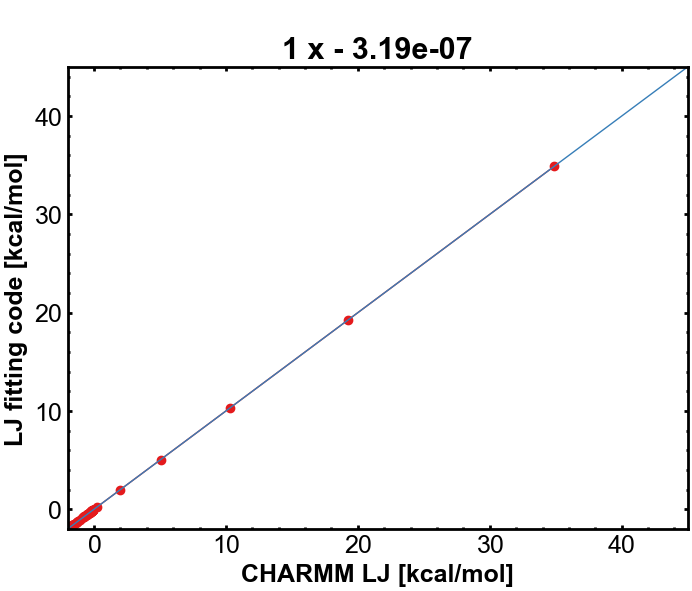

In [224]:
x = test["VDW"]
y = test["LJ"]
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
print(np.poly1d(np.polyfit(x, y, 1)))

max_val = 45

plt.scatter(test["VDW"], test["LJ"])
plt.plot([-2,max_val], [-2,max_val], )
plt.xlim(-2,max_val)
plt.ylim(-2,max_val)


plt.ylabel("LJ fitting code [kcal/mol]")
plt.xlabel("CHARMM LJ [kcal/mol]")
plt.title(np.poly1d(np.polyfit(x, y, 1)))

plt.savefig("dcm_dimer_scan_debug.pdf")


In [192]:
ff_test.debug_df[:50]

,group,es,akp,idx,gname,distances,sigmas,epsilons
0,0,-8.677698e-05,0,0,r3.1.xyz,3.100442,0.614110,0.718546
1,0,-7.505325e-01,1,1,r3.1.xyz,3.193370,3.501085,1.641240
2,0,-2.320918e-02,1,2,r3.1.xyz,3.120960,3.501085,1.641240
3,0,-4.362454e-01,1,3,r3.1.xyz,4.840674,3.501085,1.641240
4,0,7.317725e-01,1,4,r3.1.xyz,3.069389,3.501085,1.641240
5,0,6.017344e+02,2,5,r3.1.xyz,3.134569,5.251836,1.351950
6,0,3.954847e+03,2,6,r3.1.xyz,2.692313,5.251836,1.351950
7,0,9.982712e+00,2,7,r3.1.xyz,4.186816,5.251836,1.351950
8,0,3.131065e+03,2,8,r3.1.xyz,2.744182,5.251836,1.351950
9,0,1.407278e+02,3,9,r3.1.xyz,4.596207,6.388061,3.748780


In [193]:
ff_test.dists["r3.1.xyz"]

[[array([[3.10044207]])],
 [],
 [array([[3.19336954, 3.12096043]]), array([[4.84067382, 3.06938903]])],
 [array([[3.13456887, 2.69231276]]), array([[4.18681609, 2.74418185]])],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [array([[4.59620724, 4.76597545],
         [3.64436894, 3.6277125 ]])],
 [array([[5.92855033, 4.4562933 ],
         [3.96769316, 2.16205967]]),
  array([[3.58978579, 2.26284113],
         [2.54541568, 3.02264404]])],
 [],
 [],
 [],
 [],
 [],
 [array([[4.17629908, 2.94331327],
         [3.75542354, 2.61118613]])],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [195]:
test[["VDW", "LJ"]].describe()

,VDW,LJ
count,45.000000,45.000000
mean,1.073489,1.315643
std,6.207976,7.120255
min,-1.653810,-1.641574
25%,-0.812710,-0.827040
50%,-0.259480,-0.264829
75%,-0.094020,-0.095880
max,34.894040,41.451263


In [45]:
# test[["VDW", "LJ"]]

In [25]:
ff_test.num_segments

45

In [203]:
n = 100
loss = "jax"
# ff_test.num_targets = len(targets)

ff_test.set_targets()


LJFF = fit_repeat(
        ff_test, n, f"dcm_test_fitted", bounds=ff_test.bounds, loss=loss,
        quiet=False
    )



loss:  jax
(<bound method FF.get_loss_jax of FF: LJ dcmdimerscan ELEC Exact P_intE (jax_coloumb: False)>, <bound method FF.eval_jax of FF: LJ dcmdimerscan ELEC Exact P_intE (jax_coloumb: False)>)
Optimizing LJ parameters...
function: get_loss_jax
bounds: [(0.1, 5.5), (0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1), (0.001, 0.1)]
maxfev: 10000
initial guess: [0.6938727727709282, 2.1056691956603566, 2.9366960326052163, 0.06963461563032695, 0.06246247409968745, 0.013933125209618796]
final_loss_fn:  0.14435577392578125
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.14435577392578125
             x: [ 1.982e+00  2.093e+00  6.628e-01  1.000e-01  1.000e-01
                  9.999e-02]
           nit: 1162
          nfev: 1803
 final_simplex: (array([[ 1.982e+00,  2.093e+00, ...,  1.000e-01,
                         9.999e-02],
                       [ 1.982e+00,  2.093e+00, ...,  1.000e-01,
                         9.999e-02],

In [34]:
set_style()

In [205]:
print(LJFF.opt_results)
pickle_output(LJFF, f"dcm_test__fitted")
LJFF.num_segments = 45
jaxeval = LJFF.eval_jax(LJFF.get_best_parm())[0]

print(LJFF.num_segments)


print("eval_jax::", jaxeval)
jaxloss = ff_test.get_loss_jax(LJFF.get_best_parm())

print("jaxloss::", jaxloss)


elec = LJFF.data[LJFF.elec]

targets = LJFF.targets

print(len(elec), len(targets), len(jaxeval))



print("targets", targets)
residuals = targets - jaxeval
#  make the dataframe
df_test = pd.DataFrame(
    {
        "target": targets,
        "residuals": residuals,
        "vals": jaxeval
    }
).dropna()  # drop the nans
#  plot the results
residuals_plot(df_test, "dcm_test_targets", xlabel="$E_{int} - E_{Coloumb}$", ylabel="$E_{LJ}$")
print(df_test.describe())
plt.clf()


#  make the dataframe
df_test = pd.DataFrame(
    {
        "target": LJFF.data[LJFF.intE],
        "residuals": LJFF.data[LJFF.intE] - (jaxeval + elec),
        "vals": jaxeval + elec
    }
).dropna()  # drop the nans
#  plot the results
residuals_plot(df_test, "dcm_test_elec_jax", xlabel="$E_{int}$", ylabel="$E_{LJ} + E_{ELEC}$")
print(df_test.describe())

plt.clf()
print(ff_test.data)
print(LJFF.data)



[       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.14435577392578125
             x: [ 1.982e+00  2.093e+00  6.628e-01  1.000e-01  1.000e-01
                  9.999e-02]
           nit: 1162
          nfev: 1803
 final_simplex: (array([[ 1.982e+00,  2.093e+00, ...,  1.000e-01,
                         9.999e-02],
                       [ 1.982e+00,  2.093e+00, ...,  1.000e-01,
                         9.999e-02],
                       ...,
                       [ 1.982e+00,  2.093e+00, ...,  1.000e-01,
                         9.999e-02],
                       [ 1.982e+00,  2.093e+00, ...,  1.000e-01,
                         9.999e-02]]), array([ 1.444e-01,  1.444e-01,  1.444e-01,  1.444e-01,
                        1.444e-01,  1.444e-01,  1.444e-01])),        message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.14435426890850067
             x: [ 1.982e+00  2.093e+00  6.

In [207]:
ff_test.eval_jax(ff_test.p)[0]

Array([7.1264416e+07, 6.2186272e+07, 4.1093744e+07, 2.7563632e+07,
       1.8746362e+07, 1.2941160e+07, 8.9828800e+06, 6.3340560e+06,
       4.5015855e+06, 1.5025267e+08, 2.3276080e+06, 1.6959280e+06,
       1.2412590e+06, 9.1716912e+05, 6.8212012e+05, 5.0916597e+05,
       2.8953559e+05, 2.2031994e+05, 3.2197800e+06, 1.2936208e+05,
       7.7476047e+04, 6.0186250e+04, 4.7110758e+04, 3.6955227e+04,
       2.9098404e+04, 2.3011100e+04, 1.6850383e+05, 1.1567761e+04,
       9.2582305e+03, 7.4109390e+03, 5.9594053e+03, 4.7986089e+03,
       3.8670352e+03, 3.1241399e+03, 2.5288452e+03, 2.0443293e+03,
       1.4499885e+04, 1.3434534e+03, 8.8127124e+02, 7.1385529e+02,
       4.6461514e+02, 3.7331320e+02, 2.3799234e+02, 1.6579641e+03,
       1.8807086e+02], dtype=float32)

In [208]:
ff_test.targets

Array([ 7.0798173 ,  4.0173798 ,  1.8547976 ,  0.38756585, -0.58449733,
       -1.1929806 , -1.5452666 , -1.7158692 , -1.7710713 , 11.39183   ,
       -1.6684291 , -1.5694075 , -1.4536113 , -1.340374  , -1.226695  ,
       -1.1197169 , -0.931639  , -0.84662807, -1.7440695 , -0.698678  ,
       -0.5767491 , -0.5229767 , -0.4736333 , -0.42997742, -0.3915401 ,
       -0.35579908, -0.7696118 , -0.27134484, -0.24914482, -0.22929755,
       -0.21149772, -0.19546452, -0.1809299 , -0.16786325, -0.15621966,
       -0.14531343, -0.2962463 , -0.1270289 , -0.11133013, -0.10441367,
       -0.09247605, -0.087298  , -0.07766905, -0.13552767, -0.07345248],      dtype=float32)

In [209]:
# jaxeval

In [210]:
# LJ_bound

In [211]:
indexs = []
cc_dist = []
for k, v in ff_test.dists.items():
    if k in list(ff_test.data.index):
        indexs.append(k)
        cc_dist.append(v[0][0][0])

In [225]:
dist_df = pd.DataFrame({"dist": cc_dist}, index=indexs)
dist_df.sort_index(inplace=True)
dist_df

0 ('C', 'C')
1 ('C', 'CG331')
2 ('C', 'CL')
3 ('C', 'H')
4 ('C', 'HGA3')
5 ('C', 'HGP1')
6 ('C', 'HT')
7 ('C', 'OG311')
8 ('C', 'OT')
9 ('CG331', 'CG331')
10 ('CG331', 'CL')
11 ('CG331', 'H')
12 ('CG331', 'HGA3')
13 ('CG331', 'HGP1')
14 ('CG331', 'HT')
15 ('CG331', 'OG311')
16 ('CG331', 'OT')
17 ('CL', 'CL')
18 ('CL', 'H')
19 ('CL', 'HGA3')
20 ('CL', 'HGP1')
21 ('CL', 'HT')
22 ('CL', 'OG311')
23 ('CL', 'OT')
24 ('H', 'H')
25 ('H', 'HGA3')
26 ('H', 'HGP1')
27 ('H', 'HT')
28 ('H', 'OG311')
29 ('H', 'OT')
30 ('HGA3', 'HGA3')
31 ('HGA3', 'HGP1')
32 ('HGA3', 'HT')
33 ('HGA3', 'OG311')
34 ('HGA3', 'OT')
35 ('HGP1', 'HGP1')
36 ('HGP1', 'HT')
37 ('HGP1', 'OG311')
38 ('HGP1', 'OT')
39 ('HT', 'HT')
40 ('HT', 'OG311')
41 ('HT', 'OT')
42 ('OG311', 'OG311')
43 ('OG311', 'OT')
44 ('OT', 'OT')


,dist
r3.1.xyz,[3.1004420652545654]
r3.2.xyz,3.200619
r3.3.xyz,3.300669
r3.4.xyz,3.400846
r3.5.xyz,3.500293
r3.6.xyz,3.600279
r3.7.xyz,3.70052
r3.8.xyz,3.799902
r3.9.xyz,3.900748
r3.xyz,3.000392


In [226]:
# pd.merge(dist_df, LJFF.data)

# LJFF.

In [227]:
len( LJFF.data["P_intE"])

45

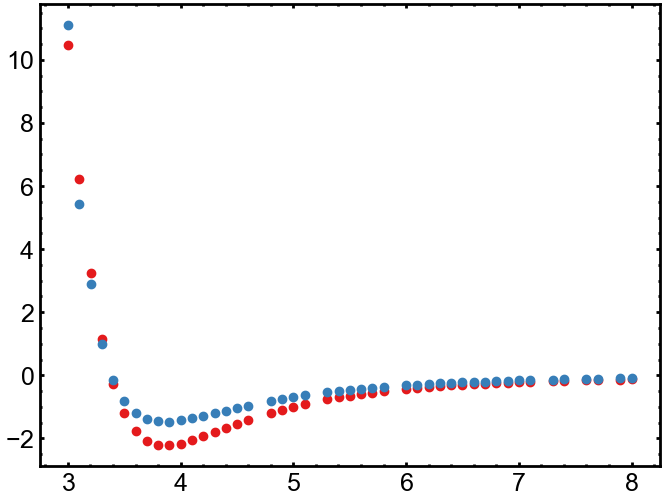

In [228]:
fig, ax = plt.subplots()


ax.scatter(dist_df["dist"], ff_test.data["P_intE"])
ax.scatter(dist_df["dist"], df_test["vals"])
# plt.show()

In [32]:
files = [ogr[float(int(_))] for _ in list(ff_test.out_groups)]
last = [files[0]]
for _ in files:
    if _ != last[-1]:
        last.append( _)
        # print(_)

NameError: name 'ogr' is not defined

In [ ]:
ff_test.data["T"] = targets
# ff_test.data

In [ ]:
# ff_test.targets

In [80]:
# last

In [87]:
ogr

{0: 'r3.1.xyz',
 1: 'r3.2.xyz',
 2: 'r3.3.xyz',
 3: 'r3.4.xyz',
 4: 'r3.5.xyz',
 5: 'r3.6.xyz',
 6: 'r3.7.xyz',
 7: 'r3.8.xyz',
 8: 'r3.9.xyz',
 9: 'r3.xyz',
 10: 'r4.1.xyz',
 11: 'r4.2.xyz',
 12: 'r4.3.xyz',
 13: 'r4.4.xyz',
 14: 'r4.5.xyz',
 15: 'r4.6.xyz',
 16: 'r4.8.xyz',
 17: 'r4.9.xyz',
 18: 'r4.xyz',
 19: 'r5.1.xyz',
 20: 'r5.3.xyz',
 21: 'r5.4.xyz',
 22: 'r5.5.xyz',
 23: 'r5.6.xyz',
 24: 'r5.7.xyz',
 25: 'r5.8.xyz',
 26: 'r5.xyz',
 27: 'r6.1.xyz',
 28: 'r6.2.xyz',
 29: 'r6.3.xyz',
 30: 'r6.4.xyz',
 31: 'r6.5.xyz',
 32: 'r6.6.xyz',
 33: 'r6.7.xyz',
 34: 'r6.8.xyz',
 35: 'r6.9.xyz',
 36: 'r6.xyz',
 37: 'r7.1.xyz',
 38: 'r7.3.xyz',
 39: 'r7.4.xyz',
 40: 'r7.6.xyz',
 41: 'r7.7.xyz',
 42: 'r7.9.xyz',
 43: 'r7.xyz',
 44: 'r8.xyz'}

In [102]:
fitted_ = {_.stem: pd.read_pickle(_) for _ in list(PKL_PATH.glob("*ELECm_dcm_lj_fitted*"))}
fitted_.keys()

fitkeys = list(fitted_.keys())
fitkeys = [
  #   'ELECnull_water_cluster_lj_fitted',
  # 'ELECci_water_cluster_lj_fitted',
  # 'ELECpol_water_cluster_lj_fitted',
  # 'ELECk_water_cluster_lj_fitted',
  # 'ELECm_water_cluster_lj_fitted',
  # 'ELECp_water_cluster_lj_fitted',
  # 'ELECnull_dcm_lj_fitted',
  # 'ELECci_dcm_lj_fitted',
  # 'ELECpol_dcm_lj_fitted',
  # 'ELECm_dcm_lj_fitted',
  # 'ELECp_dcm_lj_fitted'
]

In [118]:
debug_sum = ff.debug_df.groupby("gname").sum()

In [ ]:
ff = fitted_["ELECm_dcm_lj_fitted"]

In [120]:
ff.jax_init(LJFF.p)

2023-09-11 15:10:50 | WARNING | dispatch:log_elapsed_time:270 - Finished tracing + transforming jit(convert_element_type) in 0.0001823902130126953 sec
2023-09-11 15:10:50 | WARNING | dispatch:log_elapsed_time:270 - Finished tracing + transforming <lambda> for pjit in 0.0005002021789550781 sec
2023-09-11 15:10:50 | DEBUG | pxla:_cached_lowering_to_hlo:1879 - Compiling <lambda> for with global shapes and types [ShapedArray(float32[200]), ShapedArray(float32[200])]. Argument mapping: (GSPMDSharding({replicated}), GSPMDSharding({replicated})).
2023-09-11 15:10:50 | DEBUG | xla_bridge:get_compile_options:128 - get_compile_options: num_replicas=1 num_partitions=1 device_assignment=[[CpuDevice(id=0)]]
2023-09-11 15:10:50 | WARNING | dispatch:log_elapsed_time:270 - Finished XLA compilation of jit(<lambda>) in 0.007615089416503906 sec
2023-09-11 15:10:50 | WARNING | dispatch:log_elapsed_time:270 - Finished tracing + transforming jit(copy) in 0.00023937225341796875 sec
2023-09-11 15:10:50 | DEBU

targets:
[-6.8550601e+00 -6.8375211e+00 -1.0320949e+01 -3.0146837e+00
 -3.5869360e+00 -2.0234489e+00 -8.2330475e+00 -2.7043076e+00
 -3.1953859e+00 -1.0066981e+01 -5.2109022e+00 -5.9050674e+00
 -5.8097200e+00 -5.5400987e+00 -8.3136587e+00 -9.7961292e+00
 -5.4511900e+00 -4.7509985e+00 -9.0197277e-01 -5.0976882e+00
 -6.2584181e+00 -2.5203915e+00 -9.2267179e-01 -5.0215182e+00
 -2.3995566e+00 -7.3705206e+00 -8.0960331e+00 -8.0855474e+00
 -8.2293949e+00 -3.4293680e+00 -4.8796253e+00 -5.5910783e+00
 -7.6319351e+00 -5.9212208e+00 -6.2004533e+00 -5.4448833e+00
 -9.6716223e+00 -2.7415481e+00 -5.1012983e+00 -3.3970027e+00
 -4.1764102e+00 -5.4643755e+00 -1.1230443e+01 -7.0369716e+00
 -6.2448788e+00 -8.2465210e+00 -7.7768040e+00 -5.4082432e+00
 -1.3218880e-01  1.4789262e+00 -3.3929038e+00 -8.8888149e+00
 -6.8272839e+00 -4.4609404e+00 -6.0446835e+00 -4.6254110e+00
 -1.5102091e+00 -8.6423302e+00 -6.8167067e+00 -3.7720907e+00
 -8.6685524e+00  3.1472297e+00 -1.1224448e+01 -1.0681319e+01
 -9.7626724e+00

2023-09-11 15:10:50 | WARNING | dispatch:log_elapsed_time:270 - Finished tracing + transforming jit(convert_element_type) in 0.00022101402282714844 sec


debug
groups
342000
200
dists
342000


2023-09-11 15:10:50 | WARNING | dispatch:log_elapsed_time:270 - Finished tracing + transforming jit(convert_element_type) in 0.00036716461181640625 sec
2023-09-11 15:10:50 | WARNING | dispatch:log_elapsed_time:270 - Finished tracing + transforming jit(copy) in 0.00030422210693359375 sec
2023-09-11 15:10:50 | DEBUG | pxla:_cached_lowering_to_hlo:1879 - Compiling copy for with global shapes and types [ShapedArray(int32[342000])]. Argument mapping: (GSPMDSharding({replicated}),).
2023-09-11 15:10:50 | DEBUG | xla_bridge:get_compile_options:128 - get_compile_options: num_replicas=1 num_partitions=1 device_assignment=[[CpuDevice(id=0)]]
2023-09-11 15:10:50 | WARNING | dispatch:log_elapsed_time:270 - Finished XLA compilation of jit(copy) in 0.006351947784423828 sec


In [125]:
ff.num_segments = 200

In [126]:
LJFF.p

[1.91, 1.34, 2.01, -0.343, -0.024, -0.0561]

In [127]:
ff.eval_jax(LJFF.p) + ff.data[ff.elec]

indexs shape (array(342000, dtype=int32),)
dists shape (array(342000, dtype=int32),)
comb_parms shape (array(12, dtype=int32),)
comb_parms [3.82       3.25       2.68       3.92       3.35       4.02
 0.343      0.09073037 0.024      0.13871662 0.03669332 0.0561    ]
sigma_s (array(342000, dtype=int32),)
sigma [3.82 3.82 3.82 ... 4.02 4.02 4.02]
eps_s (array(342000, dtype=int32),)
eps [3.92  3.92  3.92  ... 0.024 0.024 0.024]


100_1018_DCM_120_967    -90.051086
100_1019_DCM_120_565    -98.459160
100_1024_DCM_121_932    -88.328529
100_1053_DCM_123_948   -116.927422
100_1100_DCM_129_15    -122.304626
                           ...    
100_979_DCM_115_117     -69.655296
100_983_DCM_116_25     -133.518799
100_986_DCM_116_989     -91.988159
100_98_DCM_12_534      -110.899071
100_992_DCM_117_761    -136.640030
Name: ELECm, Length: 200, dtype: float32

In [128]:
debug_sum

,es,akp,idx,distances,sigmas,epsilons
gname,,,,,,
100_1018_DCM_120_967,4.679388e+05,5320,1461195,17569.118617,7917.249714,2795.567132
100_1019_DCM_120_565,7.898120e+05,5320,4385295,17615.509527,7917.249714,2795.567132
100_1024_DCM_121_932,3.639569e+05,5320,7309395,17304.095044,7917.249714,2795.567132
100_1053_DCM_123_948,7.841421e+05,5320,10233495,16397.272239,7917.249714,2795.567132
100_1100_DCM_129_15,7.220288e+05,5320,13157595,16850.721284,7917.249714,2795.567132
...,...,...,...,...,...,...
100_979_DCM_115_117,3.569682e+05,5320,571660695,21309.277087,7917.249714,2795.567132
100_983_DCM_116_25,1.100597e+06,5320,574584795,15931.997308,7917.249714,2795.567132
100_986_DCM_116_989,5.042633e+05,5320,577508895,17248.964215,7917.249714,2795.567132


In [130]:
ff.debug_df

,group,es,akp,idx,gname,distances,sigmas,epsilons
0,0,-2.126215,0,0,100_1018_DCM_120_967,10.841139,9.843714,2.635503
1,0,39625.826790,0,1,100_1018_DCM_120_967,4.410378,9.843714,2.635503
2,0,-2.095797,0,2,100_1018_DCM_120_967,10.883423,9.843714,2.635503
3,0,566.582409,0,3,100_1018_DCM_120_967,6.220990,9.843714,2.635503
4,0,-0.998565,0,4,100_1018_DCM_120_967,12.748889,9.843714,2.635503
...,...,...,...,...,...,...,...,...
341995,199,-0.000890,5,341995,100_992_DCM_117_761,7.572867,2.023099,1.223674
341996,199,-0.000068,5,341996,100_992_DCM_117_761,11.620529,2.023099,1.223674
341997,199,-0.000068,5,341997,100_992_DCM_117_761,11.620529,2.023099,1.223674
341998,199,-0.000082,5,341998,100_992_DCM_117_761,11.272764,2.023099,1.223674


In [129]:
ff.eval_jax(LJFF.p)

indexs shape (array(342000, dtype=int32),)
dists shape (array(342000, dtype=int32),)
comb_parms shape (array(12, dtype=int32),)
comb_parms [3.82       3.25       2.68       3.92       3.35       4.02
 0.343      0.09073037 0.024      0.13871662 0.03669332 0.0561    ]
sigma_s (array(342000, dtype=int32),)
sigma [3.82 3.82 3.82 ... 4.02 4.02 4.02]
eps_s (array(342000, dtype=int32),)
eps [3.92  3.92  3.92  ... 0.024 0.024 0.024]


Array([ -84.494354,  -90.80817 ,  -84.28933 , -108.87056 , -112.5487  ,
       -141.51701 ,  -82.83136 ,  -71.1442  ,  -65.57733 ,  -75.317345,
        -66.49149 ,  -80.15694 , -102.78669 ,  192.76549 , -127.37871 ,
       -129.09282 ,  -97.692986,  -87.40814 , -122.916855, -106.955414,
       -106.350426, -101.344215,  -88.64106 ,  -65.972984,  -93.6203  ,
       -111.79648 , -135.19746 ,  -69.65386 ,  -64.373764,  -95.89479 ,
       -105.49974 ,  -52.03084 ,  -75.17563 ,  -91.02495 ,   78.44954 ,
        -43.213814, -110.8836  , -118.31719 , -111.09949 ,  -77.35783 ,
        -77.295265, -115.99766 , -101.77045 ,  -94.30604 ,  -77.80781 ,
       -114.06278 , -109.80912 ,  -27.8385  ,  -74.32244 ,  -78.99709 ,
       -110.53142 , -115.38822 ,  -79.16781 , -126.823875,  -63.5866  ,
       -124.94141 , -107.671616,  -79.9903  , -129.6764  ,  -70.27559 ,
        -21.173931, -114.57665 , -140.5779  , -125.356064,  -82.07911 ,
        -57.244225, -123.26249 ,  -77.54224 ,  -80.230064, -119.

In [153]:
# ff.intE
# ff.targets
ff.num_segments

200

In [154]:
n = 1
loss = "jax"
# ff_test.num_targets = len(targets)

ff.set_targets()


LJFF = fit_repeat(
        ff, n, f"dcmff_test_fitted", bounds=ff_test.bounds, loss=loss,
        quiet=False
    )

targets:
[-6.8550601e+00 -6.8375211e+00 -1.0320949e+01 -3.0146837e+00
 -3.5869360e+00 -2.0234489e+00 -8.2330475e+00 -2.7043076e+00
 -3.1953859e+00 -1.0066981e+01 -5.2109022e+00 -5.9050674e+00
 -5.8097200e+00 -5.5400987e+00 -8.3136587e+00 -9.7961292e+00
 -5.4511900e+00 -4.7509985e+00 -9.0197277e-01 -5.0976882e+00
 -6.2584181e+00 -2.5203915e+00 -9.2267179e-01 -5.0215182e+00
 -2.3995566e+00 -7.3705206e+00 -8.0960331e+00 -8.0855474e+00
 -8.2293949e+00 -3.4293680e+00 -4.8796253e+00 -5.5910783e+00
 -7.6319351e+00 -5.9212208e+00 -6.2004533e+00 -5.4448833e+00
 -9.6716223e+00 -2.7415481e+00 -5.1012983e+00 -3.3970027e+00
 -4.1764102e+00 -5.4643755e+00 -1.1230443e+01 -7.0369716e+00
 -6.2448788e+00 -8.2465210e+00 -7.7768040e+00 -5.4082432e+00
 -1.3218880e-01  1.4789262e+00 -3.3929038e+00 -8.8888149e+00
 -6.8272839e+00 -4.4609404e+00 -6.0446835e+00 -4.6254110e+00
 -1.5102091e+00 -8.6423302e+00 -6.8167067e+00 -3.7720907e+00
 -8.6685524e+00  3.1472297e+00 -1.1224448e+01 -1.0681319e+01
 -9.7626724e+00

In [156]:
ff.atom_type_pairs

[('C', 'C'), ('C', 'CL'), ('C', 'H'), ('CL', 'CL'), ('CL', 'H'), ('H', 'H')]

In [159]:
print(LJFF.opt_results)
pickle_output(LJFF, f"dcm_test__fitted")
LJFF.num_segments = 200
jaxeval = LJFF.eval_jax(LJFF.get_best_parm(), )

print(LJFF.num_segments)


print("eval_jax::", jaxeval)
jaxloss = ff.get_loss_jax(LJFF.get_best_parm())

print("jaxloss::", jaxloss)


elec = LJFF.data[LJFF.elec]

targets = LJFF.targets

print(len(elec), len(targets), len(jaxeval))



print("targets", targets)
residuals = targets - jaxeval
#  make the dataframe
df_test = pd.DataFrame(
    {
        "target": targets,
        "residuals": residuals,
        "vals": jaxeval
    }
).dropna()  # drop the nans
#  plot the results
residuals_plot(df_test, "dcm_test_targets")
print(df_test.describe())
plt.clf()


#  make the dataframe
df_test = pd.DataFrame(
    {
        "target": LJFF.data[LJFF.intE],
        "residuals": LJFF.data[LJFF.intE] - (jaxeval + elec),
        "vals": jaxeval + elec
    }
).dropna()  # drop the nans
#  plot the results
residuals_plot(df_test, "dcm_test_elec_jax")
print(df_test.describe())

plt.clf()
print(ff_test.data)
print(LJFF.data)

[       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 12.533696174621582
             x: [ 1.454e+00  1.933e-03  1.003e-03  3.193e+00  5.488e+00
                  5.500e+00]
           nit: 246
          nfev: 472
 final_simplex: (array([[ 1.454e+00,  1.933e-03, ...,  5.488e+00,
                         5.500e+00],
                       [ 1.454e+00,  1.933e-03, ...,  5.488e+00,
                         5.500e+00],
                       ...,
                       [ 1.454e+00,  1.933e-03, ...,  5.488e+00,
                         5.500e+00],
                       [ 1.454e+00,  1.933e-03, ...,  5.488e+00,
                         5.500e+00]]), array([ 1.253e+01,  1.253e+01,  1.253e+01,  1.253e+01,
                        1.253e+01,  1.253e+01,  1.253e+01])),        message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 12.06592082977295
             x: [ 1.485e+00  2.297e+00  1.073e-

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:01 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved


indexs shape (array(342000, dtype=int32),)
dists shape (array(342000, dtype=int32),)
comb_parms shape (array(12, dtype=int32),)
comb_parms [0.34518853 1.8446044  3.3440201  0.24771068 1.7471265  0.15023282
 4.5541415  2.3759565  1.2395684  1.9183946  1.0008521  0.80810785]
sigma_s (array(342000, dtype=int32),)
sigma [0.34518853 0.34518853 0.34518853 ... 0.15023282 0.15023282 0.15023282]
eps_s (array(342000, dtype=int32),)
eps [0.24771068 0.24771068 0.24771068 ... 1.2395684  1.2395684  1.2395684 ]
200
eval_jax:: [-4.440532  -4.9451904 -4.548495  -5.4934144 -5.672168  -7.1174836
 -4.2040596 -3.633995  -3.3919969 -3.771903  -3.3830662 -4.011844
 -5.731735  -4.835928  -6.131169  -6.593844  -4.877544  -4.35206
 -5.719584  -5.403006  -5.426664  -5.1045575 -4.4338665 -3.454035
 -5.2869415 -5.9499187 -7.2437162 -3.6514122 -3.3522832 -4.837257
 -5.256603  -2.7224164 -4.886544  -6.0802174 -3.4623249 -4.7938504
 -5.7396274 -5.251166  -5.754101  -4.949257  -4.056678  -5.93882
 -5.3672433 -5.094972

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:01 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:01 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:01 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:01 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:01 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:to

saving  dcm_test_targets


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:03 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
2023-09-11 15:24:03 | DEBUG | _base:_update_title_position:2966 - title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
2023-09-11 15:24:03 | DEBUG | _base:_update_title_position:2966 - title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:03 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:03 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._bas

           target   residuals        vals
count  200.000000  200.000000  200.000000
mean    -5.235604   -0.361085   -4.874519
std      3.173642    3.442436    1.326724
min    -12.734488   -7.627217   -8.481735
25%     -7.720223   -2.899379   -5.780948
50%     -5.456869   -0.825863   -4.882044
75%     -3.264148    2.149330   -3.975113
max      4.455761   11.298174   -0.831434


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:06 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:06 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:06 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:06 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:06 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:to

saving  dcm_test_elec_jax


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:08 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
2023-09-11 15:24:08 | DEBUG | _base:_update_title_position:2966 - title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
2023-09-11 15:24:08 | DEBUG | _base:_update_title_position:2966 - title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:08 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:08 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._bas

           target   residuals        vals
count  200.000000  200.000000  200.000000
mean   -12.902028   -0.361085  -12.540943
std      4.166206    3.442436    3.743724
min    -24.250399   -7.627215  -21.247763
25%    -15.957837   -2.899378  -15.328609
50%    -12.779601   -0.825863  -12.573431
75%    -10.030667    2.149329   -9.709576
max     -2.586429   11.298173   -4.026644
             TOTAL     ELEC       VDW       KEY     M_ENERGY  n_monomers  \
r3.1.xyz  19.15613 -0.84157  19.22300  r3.1.xyz -1918.743238         2.0   
r3.2.xyz  11.19794 -0.77328  10.28236  r3.2.xyz -1918.743238         2.0   
r3.3.xyz   7.22620 -0.71148   5.04008  r3.3.xyz -1918.743238         2.0   
r3.4.xyz   5.51765 -0.65623   1.99860  r3.4.xyz -1918.743238         2.0   
r3.5.xyz   5.01956 -0.60614   0.23506  r3.5.xyz -1918.743238         2.0   
r3.6.xyz   4.87844 -0.56134  -0.75695  r3.6.xyz -1918.743238         2.0   
r3.7.xyz   4.94221 -0.52025  -1.29823  r3.7.xyz -1918.743238         2.0   
r3.8.xyz   4.9

In [162]:
res = ff.eval_dist(ff.p)

['H', 'C', 'CL'] [1.91, 1.34, 2.01, -0.343, -0.024, -0.0561]
0 H
1 C
2 CL
self.p [1.91, 1.34, 2.01, -0.343, -0.024, -0.0561]
sig [2.68, 3.3499999999999996, 3.25, 4.02, 3.92, 3.82]
ep [0.024, 0.036693323643409576, 0.09073036977771005, 0.0561, 0.13871661760582255, 0.343]
epsilons {'H': -0.343, 'C': -0.024, 'CL': -0.0561}
rminhalfs {'H': 1.91, 'C': 1.34, 'CL': 2.01}
ATP:: [('C', 'C'), ('C', 'CL'), ('C', 'H'), ('CL', 'CL'), ('CL', 'H'), ('H', 'H')]
debug
groups
342000
200
dists
342000


In [165]:
ff.debug_df

,group,es,akp,idx,gname,distances,sigmas,epsilons
0,0,-2.126215,0,0,100_1018_DCM_120_967,10.841139,9.843714,2.635503
1,0,39625.826790,0,1,100_1018_DCM_120_967,4.410378,9.843714,2.635503
2,0,-2.095797,0,2,100_1018_DCM_120_967,10.883423,9.843714,2.635503
3,0,566.582409,0,3,100_1018_DCM_120_967,6.220990,9.843714,2.635503
4,0,-0.998565,0,4,100_1018_DCM_120_967,12.748889,9.843714,2.635503
...,...,...,...,...,...,...,...,...
341995,199,-0.000890,5,341995,100_992_DCM_117_761,7.572867,2.023099,1.223674
341996,199,-0.000068,5,341996,100_992_DCM_117_761,11.620529,2.023099,1.223674
341997,199,-0.000068,5,341997,100_992_DCM_117_761,11.620529,2.023099,1.223674
341998,199,-0.000082,5,341998,100_992_DCM_117_761,11.272764,2.023099,1.223674


In [164]:
res[0]

[10.841139100666497,
 4.4103775348602525,
 10.883422899069943,
 6.2209898730025275,
 12.74888897120059,
 5.286323959047534,
 8.704140164312612,
 9.388392034848138,
 8.521421301637423,
 6.463368935779544,
 10.34513900341605,
 6.597982722014358,
 15.910325075245948,
 9.352410331032317,
 4.169237939959771,
 6.038370806765678,
 9.260838298987842,
 6.036079025327617,
 11.218888625884473,
 10.708601822833828,
 10.744328224696043,
 7.3792388496375425,
 10.756811562912127,
 12.716756504706694,
 14.799711922872012,
 13.86749566432238,
 5.03164605273463,
 9.954615964465932,
 9.863778079417642,
 4.888298783830628,
 10.090984144274529,
 12.904553692398665,
 13.855379388526321,
 10.313931306732657,
 7.835405350076024,
 11.88978204173651,
 5.361472652173094,
 14.234652085667568,
 5.243838002837235,
 15.925288254848013,
 4.205223061860095,
 11.046296845549643,
 13.616275004567145,
 7.056126061799066,
 6.252006238000726,
 13.355935496999079,
 8.123131785216833,
 18.0574680949462,
 8.888233176509265,
 

In [186]:
LJFF.debug_df

AttributeError: 'FF' object has no attribute 'debug_df'